In [ ]:
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead

from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Training CNN

In [ ]:
# classification_labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
#              'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 
#              'Target']
classification_labels = ['Atelectasis', 'Effusion', 'Infiltration', 'Target']

In [ ]:
class TrainData(Dataset):
    def __init__(self, data, labels=classification_labels):
        self.data = data
        self.labels = labels

    def __len__(self) -> int:
        return len(self.data)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = f'train_png/{self.data["patientId"].iloc[idx]}.png'
        image = torchvision.io.read_image(img_name)
        image = image / 255
        
        target = {}
        for label in self.labels:
            target[label] = torch.tensor(self.data[label].iloc[idx])

        sample = {'image': image, 'labels': target, 'name': torch.tensor(idx)}

        return sample

In [ ]:
data = pd.read_csv('target.csv')
data = data.drop_duplicates(subset=['patientId'])

In [ ]:
images_train, images_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Target'])

In [ ]:
batch_size = 64
train_dataset = TrainData(images_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TrainData(images_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def plot_progress(train_losses, test_losses, train_roc_aucs, test_roc_aucs):
    clear_output(True)
    
    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    f.set_figheight(6)
    f.set_figwidth(20)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_losses, label='val loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    for label in classification_labels:
        ax2.plot(train_roc_aucs[label], label=label)
    ax2.plot(np.ones_like(train_losses), '--', label='100% ROC-AUC')
    ax2.plot(np.ones_like(train_losses) * 0.5, '--', label='50% ROC-AUC')
    ax2.set_title('Train ROC-AUC')
    ax2.set_ylabel('ROC-AUC')
    ax2.set_xlabel('Batch number')

    for label in classification_labels:
        ax3.plot(test_roc_aucs[label], label=label)
    ax3.plot(np.ones_like(train_losses), '--', label='100% ROC-AUC')
    ax3.plot(np.ones_like(train_losses) * 0.5, '--', label='50% ROC-AUC')
    ax3.set_title('Test ROC-AUC')
    ax3.set_ylabel('ROC-AUC')
    ax3.set_xlabel('Batch number')
    ax3.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0)

    plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class MultilabelModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(pretrained=False)
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.resnet = self.resnet.to(device)

        self.atelectasis = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=512, out_features=2)
            )
        self.effusion = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=512, out_features=2)
            )
        self.infiltration = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=512, out_features=2)
            )
        self.target = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=512, out_features=2)
            )

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)

        return {'Atelectasis': self.atelectasis(x),
                'Effusion': self.effusion(x),
                'Infiltration': self.infiltration(x),
                'Target': self.target(x)}
    
    def get_features(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        
        return x

In [ ]:
def multilabel_criterion(loss_func, outputs, labels):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key], labels[key].to(device))
    return losses

In [ ]:
model = MultilabelModel()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

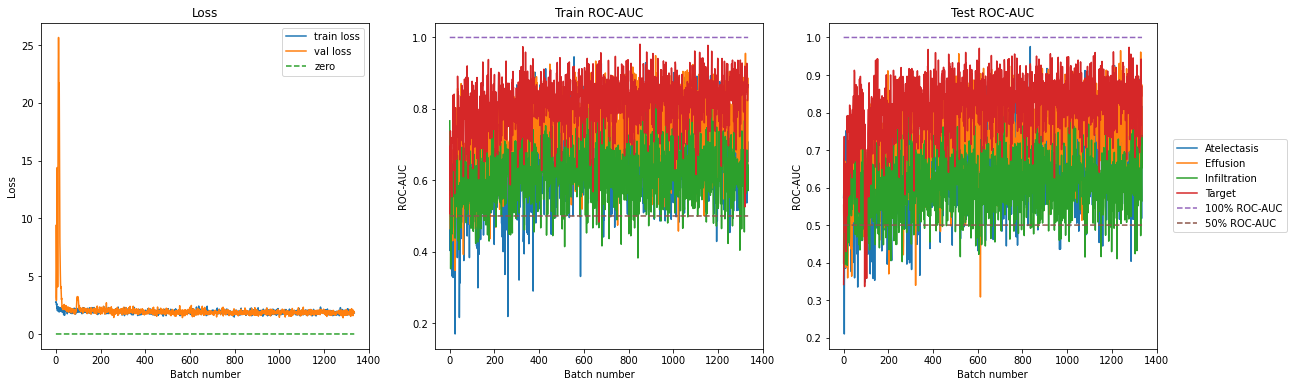

In [ ]:
epochs = 4

train_roc_aucs = {label: [] for label in classification_labels}
test_roc_aucs = {label: [] for label in classification_labels}
default_roc_auc = 0.5

train_losses = []
test_losses = []

for epoch in range(epochs):
    correct_train = 0
    correct_test = 0
    for train_batch in train_dataloader:
        model.train()
        data_train = train_batch['image'].to(device)
        target_train = train_batch['labels']

        optimizer.zero_grad()
        out_train = model(data_train.float())
        train_loss = multilabel_criterion(criterion, out_train, target_train)

        for label in classification_labels:
            preds_train = torch.nn.functional.softmax(out_train[label], 1)[:, 1]
            try:
                train_roc_aucs[label].append(roc_auc_score(train_batch['labels'][label].numpy(), 
                                                       preds_train.detach().cpu().numpy()))
            except ValueError:
                train_roc_aucs[label].append(default_roc_auc)

        train_loss.backward()
        optimizer.step()
        
        test_batch = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = test_batch['image'].to(device)
            target_test = test_batch['labels']

            out_test = model(data_test.float())
            test_loss = multilabel_criterion(criterion, out_test, target_test)

            for label in classification_labels:
                preds_test = torch.nn.functional.softmax(out_test[label], 1)[:, 1]
                try:
                    test_roc_aucs[label].append(roc_auc_score(test_batch['labels'][label].numpy(), 
                                                            preds_test.detach().cpu().numpy()))
                except ValueError:
                    test_roc_aucs[label].append(default_roc_auc)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())   
        
        plot_progress(train_losses, test_losses, train_roc_aucs, test_roc_aucs)
    scheduler.step()

torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, f'weights/resnet_18_multilabel_1_epoch_{epoch}.pt')

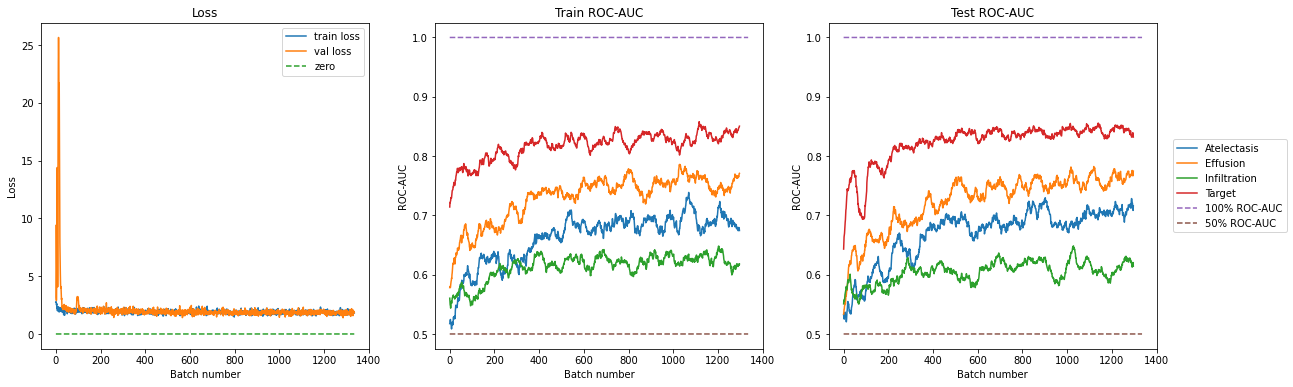

In [ ]:
w = 40
train_roc_aucs_mov = {label: np.convolve(np.array(train_roc_aucs[label]), np.ones(w), 'valid') / w for label in classification_labels}
test_roc_aucs_mov = {label: np.convolve(np.array(test_roc_aucs[label]), np.ones(w), 'valid') / w for label in classification_labels}
plot_progress(train_losses, test_losses, train_roc_aucs_mov, test_roc_aucs_mov)

In [ ]:
correct_test = {label: [] for label in classification_labels}
predicted_test = {label: [] for label in classification_labels}

model.eval()
for test_batch in test_dataloader:
    with torch.no_grad():
        data_test = test_batch['image'].to(device)
        out_test = model(data_test.float())
        
        for label in classification_labels:
            correct_test[label] += test_batch['labels'][label].tolist()

            preds_test = torch.nn.functional.softmax(out_test[label], 1)[:, 1]
            predicted_test[label] += preds_test.detach().cpu().numpy().tolist()


for label in classification_labels:
    print(f'ROC-AUC {label}: {roc_auc_score(correct_test[label], predicted_test[label])}')

ROC-AUC Atelectasis: 0.7014626806216585
ROC-AUC Effusion: 0.7541499257499258
ROC-AUC Infiltration: 0.6157482643915726
ROC-AUC Target: 0.8403159184511103


## Image retrieval

In [ ]:
checkpoint = torch.load('weights/resnet_18_multilabel_1_epoch_3.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
test_shape = len(test_dataset)
test_array = np.zeros((test_shape, 512))
test_y_a = np.zeros(test_shape)
test_y_e = np.zeros(test_shape)
test_y_i = np.zeros(test_shape)
test_y_t = np.zeros(test_shape)
test_names = np.zeros(test_shape)

with torch.no_grad():
    for i, sample in tqdm(enumerate(test_dataloader), total=84):
        l = i * batch_size
        r = min((i + 1) * batch_size, test_shape)

        test_y_a[l : r] = sample['labels']['Atelectasis']
        test_y_e[l : r] = sample['labels']['Effusion']
        test_y_i[l : r] = sample['labels']['Infiltration']
        test_y_t[l : r] = sample['labels']['Target']

        out_test = model.get_features(sample['image'].to(device).float())
        out_test = torch.squeeze(out_test).detach().cpu().numpy()
        test_array[l : r, :] = out_test

        test_names[l : r] = sample['name']

100%|██████████| 84/84 [28:56<00:00, 20.67s/it]


In [ ]:
train_shape = len(train_dataset)
train_array = np.zeros((train_shape, 512))
train_y_a = np.zeros(train_shape)
train_y_e = np.zeros(train_shape)
train_y_i = np.zeros(train_shape)
train_y_t = np.zeros(train_shape)
train_names = np.zeros(train_shape)

with torch.no_grad():
    for i, sample in tqdm(enumerate(train_dataloader), total=334):
        l = i * batch_size
        r = min((i + 1) * batch_size, train_shape)

        train_y_a[l : r] = sample['labels']['Atelectasis']
        train_y_e[l : r] = sample['labels']['Effusion']
        train_y_i[l : r] = sample['labels']['Infiltration']
        train_y_t[l : r] = sample['labels']['Target']

        out_train = model.get_features(sample['image'].to(device).float())
        out_train = torch.squeeze(out_train).detach().cpu().numpy()
        train_array[l : r, :] = out_train

        train_names[l : r] = sample['name']

 40%|███▉      | 133/334 [45:33<1:09:10, 20.65s/it]

In [ ]:
with open('arrays_multilabel.npy', 'wb') as f:
    np.save(f, test_array)
    np.save(f, test_y_a)
    np.save(f, test_y_e)
    np.save(f, test_y_i)
    np.save(f, test_y_t)
    np.save(f, train_array)
    np.save(f, train_y_a)
    np.save(f, train_y_e)
    np.save(f, train_y_i)
    np.save(f, train_y_t)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_array, train_y_t)
y_pred = neigh.predict(test_array)
accuracy_score(test_y_t, y_pred)

0.8004496908375491

### Retrieved images

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(20, 6))
image = torchvision.io.read_image(f"train_png/{data['patientId'].iloc[test_names[0]]}.png").permute(1,2,0).numpy()
axes[0].imshow(image)
axes[0].set_title(f'Query image, ')
axes[0].axis('off')

for i, name in enumerate(train_names[]):
    image = torchvision.io.read_image(f"train_png/{data['patientId'].iloc[name]}.png").permute(1,2,0).numpy()
    axes[i + 1].imshow(image)
    axes[i + 1].set_title(f'Retrieved image {i}, ')
    axes[i + 1].axis('off')
plt.show()